In [5]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import seaborn as sns
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split, StratifiedKFold, cross_validate
from sklearn.metrics import precision_recall_fscore_support, make_scorer, recall_score, f1_score, confusion_matrix, precision_score, balanced_accuracy_score
from sklearn.metrics import fbeta_score, classification_report


from sklearn.preprocessing import LabelEncoder, MinMaxScaler

from libs.print_cm import print_cm
from libs.loader import load_malicious,load_jobchange

         

from sklearn.model_selection import learning_curve, validation_curve

In [6]:
#Some labels
ds_labels = {1:'dataset-01: Malicious Hack', 2:'dataset-02: Job Change'}

#Load the two datset
job_data = load_jobchange()
mal_data = load_malicious()


In [13]:


scorer_job = make_scorer(f1_score)
scorer_mal = scorer = make_scorer(recall_score)

svc_job = SVC( class_weight='balanced', max_iter=200000, random_state=0)
svc_mal = SVC( class_weight='balanced', max_iter=200000, random_state=0)




##  Hyperparam stuff

In [9]:
def eval_hyperparam(estimator, data, param_name='nothing', range_list=[], range_override=[], scorer=None):
    strat_cv = StratifiedKFold(n_splits=5, random_state=0, shuffle=True)
    X,y = data
    
    dt_train_scores,dt_test_scores = validation_curve(
        estimator, X, y, param_name=param_name, param_range=range_list,
        scoring=scorer, cv=strat_cv, n_jobs=-1)
    
    train_scores_mean = np.mean(dt_train_scores, axis=1)
    test_scores_mean = np.mean(dt_test_scores, axis=1)
    x_vals = range_override  if len(range_override) > 0 else range_list
    
    df_1 = pd.DataFrame({'x':x_vals,'train':train_scores_mean,'test':test_scores_mean} )
#     print(df_1)
    return df_1
    

In [35]:
def plot(df_1, metric_name, x_label, title, ds_id, figsize = [7,5], show=False, log_x=False):
    fig = plt.figure(figsize=figsize, facecolor='w')
    axs = fig.add_subplot(111)
    axs.plot(df_1['x'], df_1['train'], label='Train', linewidth=0.75)
    axs.plot(df_1['x'], df_1['test'], label='Validation', linewidth=0.75)
    axs.legend(); axs.set_ylabel("Metric: %s"%metric_name); axs.set_xlabel(x_label)
    title_out = "SVM Hyperparameter:\n%s\n%s"%(title, ds_labels[ds_id])
    axs.set_title(title_out)
    if show:
        plt.show()
    if log_x:
        axs.set_xscale('log')
        
    fig.savefig('plots/svm_%d_hyper_%s.png'%(ds_id,x_label),bbox_inches='tight')
    plt.close(fig=fig)

In [20]:
def plot_bar(df, metric_name='', ds_id=0):
    
    N=len(df['x']); ind = np.arange(N);width = 0.3
    fig = plt.figure()
    axs = fig.add_subplot(111)
    
    axs.bar(ind, df['train'], width, label='Train')
    axs.bar(ind+width, df['test'], width,label='Validate')
    axs.set_xticks(ind + width / 2)
    axs.set_xticklabels( df['x'] )
    axs.legend(); axs.set_ylabel("Metric: %s" %metric_name); axs.set_xlabel('Kernel Type')
    
    title = "SVM Hyperparameter:\nKernel\n%s" % ds_labels[ds_id]
    axs.set_title(title)
    plt.show()
    fig.savefig('plots/svm_%d_kernel.png'%ds_id,bbox_inches='tight')
    plt.close(fig=fig)
    
    

## hyperparams

In [ ]:

kernel_range = ['linear', 'rbf', 'sigmoid','poly']

df_1 = eval_hyperparam(svc_mal, mal_data, param_name='kernel', range_list=kernel_range, scorer=scorer_mal)
df_2 = eval_hyperparam(svc_job, job_data, param_name='kernel', range_list=kernel_range, scorer=scorer_job)
print("done")

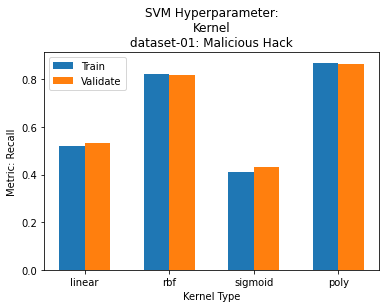

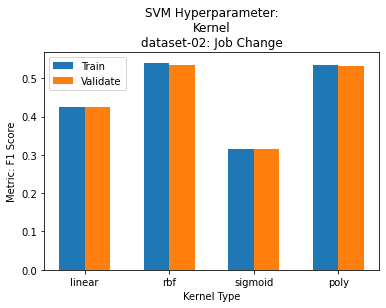

In [24]:
plot_bar(df_1,metric_name="Recall", ds_id=1)
plot_bar(df_2,metric_name="F1 Score", ds_id=2)


In [26]:
svc_mal_poly = SVC(kernel='poly', class_weight='balanced', max_iter=100000, random_state=0)
range_list_degree = np.linspace(1,10,10)
svc_job_rbf = SVC(kernel='rbf', class_weight='balanced', max_iter=100000, random_state=0)
range_list_gamma  = np.logspace(-4, 3, 10)

In [ ]:
df_3 = eval_hyperparam(svc_mal_poly, mal_data, param_name='degree', range_list=range_list_degree, scorer=scorer_mal)
df_4 = eval_hyperparam(svc_job_rbf, job_data, param_name='gamma', range_list=range_list_gamma, scorer=scorer_job)
print("done")

In [45]:
plot(df_3, 'Recall', 'degree', 'Ploynomial Degree', 1, show=False)
plot(df_4, 'F1 Score', 'gamma', 'RBF Gamma', 2 ,show=False, log_x=True)

In [30]:
svc_mal_poly_deg = SVC(kernel='poly', class_weight='balanced', degree=6, random_state=0)
range_list_mal_iter = np.logspace(1,5,15).astype('int32')
svc_job_rbf_gamma = SVC(kernel='rbf', class_weight='balanced', gamma=0.0036, random_state=0)
range_list_job_iter = np.logspace(1,5,16).astype('int32')


In [ ]:
df_5 = eval_hyperparam(svc_mal_poly_deg, mal_data, param_name='max_iter', range_list=range_list_mal_iter, scorer=scorer_mal)
df_6 = eval_hyperparam(svc_job_rbf_gamma, job_data, param_name='max_iter', range_list=range_list_job_iter, scorer=scorer_job)

In [49]:
# df_5

In [46]:
plot(df_5, 'Recall', 'iterations', 'Iterations Count', 1, show=False, log_x=True)
plot(df_6, 'F1 Score', 'iterations', 'Iteration Count', 2 ,show=False, log_x=True)